In [2]:
cd ..

/home/wesg/research/neuron-stats


In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [5]:
neuron_df = pd.read_csv('dataframes/neuron_dfs/stanford-gpt2-medium-a.csv')

In [6]:
_, BOS_cache = model.run_with_cache(model.to_tokens(""))

In [7]:
from fancy_einsum import einsum
BOS_k_dir = torch.stack([BOS_cache['k', i][0,0] for i in range(model.cfg.n_layers)])
W_out = model.W_out.cpu() / model.W_out.cpu().norm(dim=-1, keepdim=True)
bias_eff = (einsum('Al h d_h, Ql n d_m, Al h d_m d_h -> h n Al Ql', BOS_k_dir.cpu(), W_out, model.W_Q.cpu()))/np.sqrt(model.cfg.d_head)
# For each neurons and attention heads, take the difference in the attention score due to a unit activation and its composition with b_Q
causal_bias_eff = einops.rearrange(bias_eff.tril(diagonal=-1), 'h n Al Ql -> Al h Ql n')
# Only neurons before heads
sorted_bias_n, sorted_bias_n_inds = causal_bias_eff.abs().sort(dim=-1)
# Sort to find the top pair

In [8]:
W_out_random = torch.randn_like(model.W_out.cpu())
W_out_random = W_out_random / W_out_random.norm(dim=-1, keepdim=True)
bias_eff_random = (einsum('Al h d_h, Ql n d_m, Al h d_m d_h -> h n Al Ql', BOS_k_dir.cpu(), W_out_random, model.W_Q.cpu()))/np.sqrt(model.cfg.d_head)
# For each neurons and attention heads, take the difference in the attention score due to a unit activation and its composition with b_Q
causal_bias_eff_random = einops.rearrange(bias_eff_random.tril(diagonal=-1), 'h n Al Ql -> Al h Ql n')
sorted_bias_n_random, sorted_bias_n_inds_random = causal_bias_eff_random.abs().sort(dim=-1)


In [9]:
bias_eff_random.tril(diagonal=-1).shape

torch.Size([16, 4096, 24, 24])

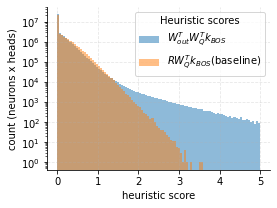

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))
bins = np.linspace(0, 5, 100)
ax.hist(sorted_bias_n.flatten().numpy(), log=True, alpha=0.5, bins=bins, label='$W_{out}^T W_Q^T k_{BOS}$');
ax.hist(sorted_bias_n_random.flatten().numpy(), log=True, alpha=0.5, bins=bins, label='$R W_Q^T k_{BOS}$(baseline)');
ax.legend(title='Heuristic scores', loc='upper right')

ax.set_xlabel('heuristic score')
ax.set_ylabel('count (neurons x heads)')

# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.3, linestyle='--')


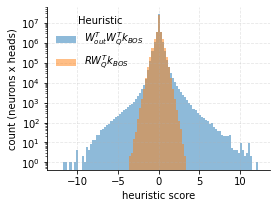

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))
bins = np.linspace(-12.5, 12.5, 100)
ax.hist(causal_bias_eff.flatten().numpy(), log=True, alpha=0.5, bins=bins, label='$W_{out}^T W_Q^T k_{BOS}$');
ax.hist(causal_bias_eff_random.flatten().numpy(), log=True, alpha=0.5, bins=bins, label='$R W_Q^T k_{BOS}$');
ax.legend(title='Heuristic', loc='upper left', frameon=False)

ax.set_xlabel('heuristic score')
ax.set_ylabel('count (neurons x heads)')

# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.3, linestyle='--')


In [19]:
act_df = pd.read_csv('dataframes/bos_signal/A5H0L4N0_12288dp.csv')
deact_df = pd.read_csv('dataframes/bos_signal/A5H14L4N0_12288dp.csv')

In [ ]:
df

,Activation Diff,Norm Diff,BOS Prob Diff
0,-0.096058,0.103492,-0.054467
1,-0.073524,0.095131,-0.050832
2,-0.112726,0.186655,-0.084938
3,-0.094086,0.100293,-0.056028
4,-0.135480,0.158246,-0.087747
...,...,...,...
12283,-0.016906,0.003301,-0.005601
12284,-0.016728,0.002627,-0.005095
12285,-0.016452,0.002566,-0.005009
12286,-0.016453,0.002361,-0.004812


In [38]:
def plot_main_bos_signal(plot_df, plot_3=True):
    df = plot_df.copy()
    df['Fractional Norm Diff'] *= 100
    fig, axs = plt.subplots(1, 3 if plot_3 else 2, figsize=(12 if plot_3 else 8, 3))

    COL_PAIRS = [
        ('Activation Diff', 'BOS Prob Diff'),
        ('BOS Prob Diff', 'Fractional Norm Diff'),
        ('Activation Diff', 'Fractional Norm Diff')
    ]
    DISPLAY_NAMES = {
        'Activation Diff': 'neuron activation pre-ablation',
        'BOS Prob Diff': 'p(BOS) ablated - p(BOS) nominal',
        'Fractional Norm Diff': 'attention out norm change (%)'
    }
    if not plot_3:
        COL_PAIRS = COL_PAIRS[:-1]
    # plot scatter plots of all pairs of columns
    for i, (col1, col2) in enumerate(COL_PAIRS):
        ax = axs[i]
        ax.scatter(df[col1], df[col2], s=1, alpha=0.5)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.grid(alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel(DISPLAY_NAMES[col1])
        ax.set_ylabel(DISPLAY_NAMES[col2])

        # compute correlation
        corr = df[col1].corr(df[col2])

        # add best fit line
        m, b = np.polyfit(df[col1], df[col2], 1)
        ax.plot(df[col1], m*df[col1] + b, color='red', alpha=0.5, label=f'best fit ($\\rho$={corr:.2f})')
        
        # add legend with blue dot for ablation result bigger than pictured
        ax.scatter([], [], color='tab:blue', label='ablation result', s=10)
        ax.legend()

    plt.tight_layout()
    return axs

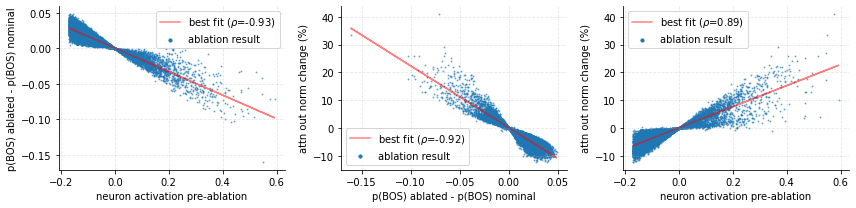

In [37]:
plot_main_bos_signal(act_df)

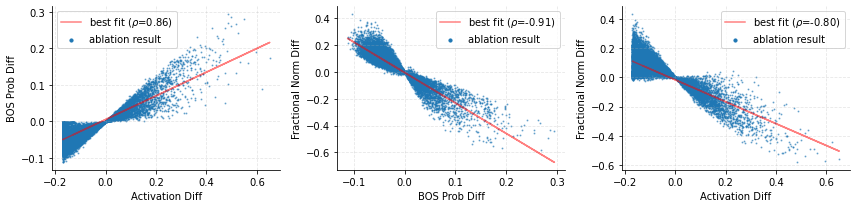

In [33]:
plot_main_bos_signal(deact_df)

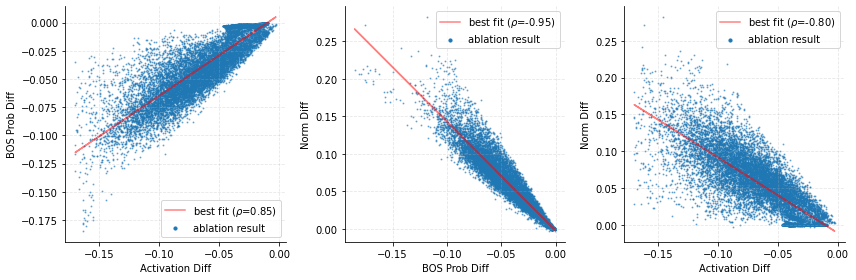

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

col_pairs = [
    ('Activation Diff', 'BOS Prob Diff'),
    ('BOS Prob Diff', 'Norm Diff'),
    ('Activation Diff', 'Norm Diff')
]
# plot scatter plots of all pairs of columns
for i, (col1, col2) in enumerate(col_pairs):
    ax = axs[i]
    ax.scatter(df[col1], df[col2], s=1, alpha=0.5)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # compute correlation
    corr = df[col1].corr(df[col2])

    # add best fit line
    m, b = np.polyfit(df[col1], df[col2], 1)
    ax.plot(df[col1], m*df[col1] + b, color='red', alpha=0.5, label=f'best fit ($\\rho$={corr:.2f})')
    
    # add legend with blue dot for ablation result bigger than pictured
    ax.scatter([], [], color='tab:blue', label='ablation result', s=10)
    ax.legend()

plt.tight_layout()

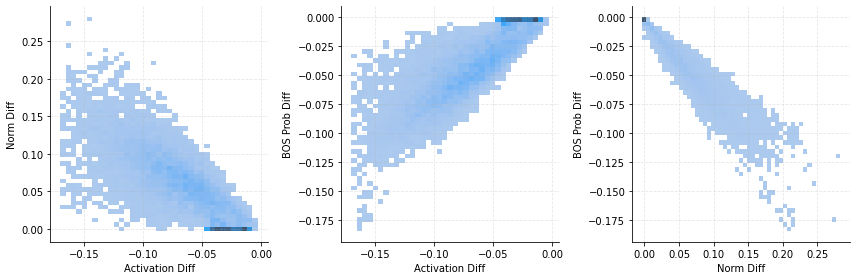

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

col_pairs = [
    ('Bos Prob Diff', 'Norm Diff'),
]
# plot scatter plots of all pairs of columns
for i, (col1, col2) in enumerate(itertools.combinations(cols, 2)):
    ax = axs[i]
    sns.histplot(df, x=col1, y=col2, ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()

In [ ]:
head_effect = einops.rearrange(causal_bias_eff, 'Al h Ql n -> (Ql n) (Al h)')
head_df = pd.DataFrame(head_effect.numpy())
head_df.columns = [f'{l}.{h}' for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)]
head_df.index = pd.MultiIndex.from_tuples([
    (l, n) for l in range(model.cfg.n_layers) 
    for n in range(model.cfg.d_mlp)], 
    names=['layer', 'neuron']
)
best_head = head_df.abs().idxmax(axis=1)
best_value = head_df.lookup(best_head.index, best_head.values)

In [19]:
causal_bias_eff.min()

tensor(-11.6672)

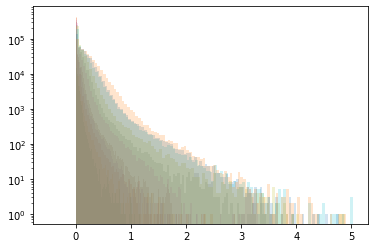

In [14]:
for i in range(12):
    plt.hist(sorted_bias_n[i].flatten().numpy(), bins=100, log=True, alpha=0.2, label=i);

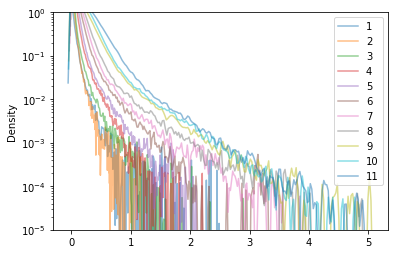

In [19]:
for i in range(1, 12):
    sns.kdeplot(sorted_bias_n[i].flatten().numpy(), alpha=0.5, label=i);
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.legend()